In [218]:
!pip install arxiv sentence-transformers faiss-cpu transformers torch rapidfuzz

In [219]:
import os
import re
import json
from typing import List, Dict, Tuple

import arxiv
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
from rapidfuzz import process, fuzz
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt


ARXIV_QUERY = "cat:cs.LG"
MAX_RESULTS = 300
EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
FAISS_INDEX_PATH = 'faiss_index.bin'
METADATA_PATH = 'metadata.json'
LLM_NAME = 'google/flan-t5-small'

In [244]:
def fetch_arxiv(query: str, max_results: int) -> List[Dict]:
    client = arxiv.Client()
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )
    results = []

    try:
          for r in client.results(search):
            results.append({
                'title': r.title,
                'authors': [a.name for a in r.authors],
                'summary': r.summary
            })
    except arxiv.UnexpectedEmptyPageError as e:
          print(f"Stopped fetching results: {e}")

    return results

In [245]:
articles = fetch_arxiv(query=ARXIV_QUERY, max_results=MAX_RESULTS)

In [246]:
print(len(articles))

300


In [247]:
def articles_eda(articles: any):
  word_counts = [len(entry["summary"].split()) for entry in articles]

  plt.hist(word_counts, bins=10, edgecolor='black')
  plt.xlabel("Number of words")
  plt.ylabel("Amount of articles")
  plt.title("Distribution of articles by 'summary' word length")
  plt.show()


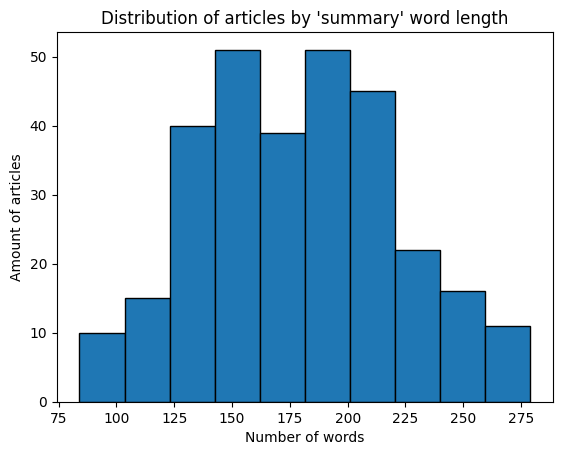

In [248]:
articles_eda(articles)

In [249]:
CHUNK_SIZE_WORDS = 175
CHUNK_OVERLAP_WORDS = 40

In [250]:
def split_into_chunks(text: str, chunk_size_words=CHUNK_SIZE_WORDS, overlap_words=CHUNK_OVERLAP_WORDS) -> List[str]:
    words = re.findall(r"\b[\w'-]+\b", text)
    chunks = []
    i = 0
    while i < len(words):
        chunk_words = words[i:i+chunk_size_words]
        chunks.append(' '.join(chunk_words))
        i += chunk_size_words - overlap_words
    return chunks

In [251]:
def build_embeddings_and_faiss(corpus_chunks: List[str], model_name=EMBEDDING_MODEL_NAME) -> Tuple[faiss.IndexFlatIP, np.ndarray]:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(corpus_chunks, show_progress_bar=True, convert_to_numpy=True)
    faiss.normalize_L2(embeddings)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)
    return index, embeddings

In [252]:
def save_index(index: faiss.IndexFlatIP, path=FAISS_INDEX_PATH):
    faiss.write_index(index, path)

In [253]:
def load_index(path=FAISS_INDEX_PATH):
    return faiss.read_index(path)

In [254]:
def prepare_corpus_and_index(articles: List[Dict]):
    chunks = []
    chunk_meta = []
    for art in articles:
        cs = split_into_chunks(art['summary'])
        for idx, c in enumerate(cs):
            chunks.append(c)
            chunk_meta.append({'title': art['title'], 'authors': art['authors'], 'chunk_index': idx})
    index, embeddings = build_embeddings_and_faiss(chunks)
    with open(METADATA_PATH, 'w', encoding='utf-8') as f:
        json.dump({'chunks': chunks, 'chunk_meta': chunk_meta, 'articles': articles}, f, ensure_ascii=False, indent=2)
    save_index(index)
    return index, chunks, chunk_meta

In [255]:
def create_vocabulary_from_corpus(chunks: List[str], top_k=2000) -> List[str]:
    freq = {}
    for c in chunks:
        for w in re.findall(r"\w+", c.lower()):
            freq[w] = freq.get(w, 0) + 1
    vocab = [w for w, _ in sorted(freq.items(), key=lambda x: x[1], reverse=True)][:top_k]
    return vocab

In [256]:
def correct_query_typos(query: str, vocab: List[str], scorer=fuzz.WRatio, limit=2) -> str:
    tokens = re.findall(r"\w+", query)
    corrected_tokens = []
    for t in tokens:
        matches = process.extract(t.lower(), vocab, scorer=scorer, limit=1)
        if matches:
            best, score, _ = matches[0]
            if score >= 93 and best != t.lower():
                corrected_tokens.append(best)
            else:
                corrected_tokens.append(t)
        else:
            corrected_tokens.append(t)
    return ' '.join(corrected_tokens)

In [257]:
def retrieve(query: str, index: faiss.IndexFlatIP, chunks: List[str], top_k=5, model_name=EMBEDDING_MODEL_NAME) -> List[Tuple[int, float]]:
    model = SentenceTransformer(model_name)
    q_emb = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb, top_k)
    return list(zip(I[0].tolist(), D[0].tolist()))

In [258]:
class LLM:
    def __init__(self, model_name=LLM_NAME):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    def generate(self, prompt: str, max_length=256) -> str:
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = self.model.generate(**inputs, max_length=max_length)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

In [268]:
def build_rag_prompt(retrieved_chunks: List[str], user_query: str, instruction: str="You're assistant with specialization in machine learning, help with the following request using provied context. Response should be concise") -> str:
    context = '\n'.join(retrieved_chunks)
    prompt = f"{instruction}: {user_query}\n\nContext:\n{context}"
    return prompt

def answer_with_rag(user_query: str, index: faiss.IndexFlatIP, chunks: List[str], chunk_meta: List[Dict], vocab: List[str], llm: LLM, top_k=5) -> Dict:
    corrected_query = correct_query_typos(user_query, vocab)
    prompt = build_rag_prompt([], corrected_query)
    answer = llm.generate(corrected_query)

    results = retrieve(corrected_query, index, chunks, top_k=top_k)
    retrieved_texts = [chunks[i] for i, _ in results]
    rag_prompt = build_rag_prompt(retrieved_texts, corrected_query)
    rag_answer = llm.generate(rag_prompt)
    return {
        'corrected_query': corrected_query,
        'retrieved_chunks_idx_and_scores': results,
        'prompt': prompt,
        'answer': answer,
        'rag_prompt': rag_prompt,
        'rag_answer': rag_answer
    }



In [260]:
index, chunks, chunk_meta = prepare_corpus_and_index(articles)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [261]:
print("Chunk examples:\n",chunks[0],"\n",chunks[int(len(chunks)/2)],"\n",chunks[int(len(chunks)*3/4)])

Chunk examples:
 The efficiency of large language models LLMs is fundamentally limited by their sequential token-by-token generation process We argue that overcoming this bottleneck requires a new design axis for LLM scaling increasing the semantic bandwidth of each generative step To this end we introduce Continuous Autoregressive Language Models CALM a paradigm shift from discrete next-token prediction to continuous next-vector prediction CALM uses a high-fidelity autoencoder to compress a chunk of K tokens into a single continuous vector from which the original tokens can be reconstructed with over 99 9 accuracy This allows us to model language as a sequence of continuous vectors instead of discrete tokens which reduces the number of generative steps by a factor of K The paradigm shift necessitates a new modeling toolkit therefore we develop a comprehensive likelihood-free framework that enables robust training evaluation and controllable sampling in the continuous domain Experiment

In [262]:
vocab = create_vocabulary_from_corpus(chunks)

In [263]:
llm = LLM()

In [264]:
questions = [
    "What is Combinatorial Fusion Analysis?",
    "What's the best algorithm?",
    "What are typical mistakes?",
    "How to improve model efficency?",
    "List model learning algorithms"
]

In [272]:
for question in questions:
    result = answer_with_rag(question, index, chunks, chunk_meta, vocab, llm, top_k=10)
    print("question:", question)
    print("------------------------------------------------")
    print("answer:", result['answer'])
    print("rag_answer:", result['rag_answer'])
    print("------------------------------------------------")
    print("corrected_query:", result['corrected_query'])
    print("rag_prompt:", result['rag_prompt'])
    print("------------------------------------------------")
    print("------------------------------------------------")

question: What is Combinatorial Fusion Analysis?
------------------------------------------------
answer: Combinatorial Fusion Analysis The combination of fusion and fusion analysis is a method of combining fusion and fusion.
rag_answer: a novel approach to sentiment classification using the application of Combinatorial Fusion Analysis CFA to integrate an ensemble of diverse machine learning models achieving state-of-the-art accuracy on the IMDB sentiment analysis dataset of 97 072 CFA leverages the concept of cognitive diversity which utilizes rank-score characteristic functions to quantify the dissimilarity between models and strategically combine their predictions
------------------------------------------------
corrected_query: What is Combinatorial Fusion Analysis
rag_prompt: You're assistant with specialization in machine learning, help with the following request using provied context. Response should be concise: What is Combinatorial Fusion Analysis

Context:
This paper presents